In [23]:
import anndata as ad
import pandas as pd
import anndata as ad
import scanpy as sc
import os
import random

In [24]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [25]:
import sys
sys.path.insert(0, '/home/jupyter/scFM_eval_')
from evaluation.eval import EmbeddingEvaluator

In [26]:
from os.path import join

In [27]:
base_dir = '/home/jupyter/mnt/__output_clean/brca_full/cell_type'

gf_model_files = [
    'hvg',
    'pca',
    # 'scgpt',
    # 'scgpt_cancer',
    'scvi_donor_id',
    'Geneformer-V2-104M',
                  'Geneformer-V2-104M_CLcancer',
                  # 'Geneformer-V2-104M_continue',
                  'Geneformer-V2-316M',
                  'gf-6L-30M-i2048',
                  'gf-6L-30M-i2048_continue'
                 ]



In [28]:
base_dir

'/home/jupyter/mnt/__output_clean/brca_full/cell_type'

In [29]:
subfolders =[entry.path for entry in os.scandir(base_dir) if entry.is_dir()]
subfolders

['/home/jupyter/mnt/__output_clean/brca_full/cell_type/Geneformer-V2-104M_continue',
 '/home/jupyter/mnt/__output_clean/brca_full/cell_type/Geneformer-V2-104M_CLcancer',
 '/home/jupyter/mnt/__output_clean/brca_full/cell_type/hvg',
 '/home/jupyter/mnt/__output_clean/brca_full/cell_type/Geneformer-V2-316M',
 '/home/jupyter/mnt/__output_clean/brca_full/cell_type/Geneformer-V2-104M',
 '/home/jupyter/mnt/__output_clean/brca_full/cell_type/scgpt_cancer',
 '/home/jupyter/mnt/__output_clean/brca_full/cell_type/scfoundation',
 '/home/jupyter/mnt/__output_clean/brca_full/cell_type/scgpt',
 '/home/jupyter/mnt/__output_clean/brca_full/cell_type/cellplm',
 '/home/jupyter/mnt/__output_clean/brca_full/cell_type/scimilarity',
 '/home/jupyter/mnt/__output_clean/brca_full/cell_type/pca',
 '/home/jupyter/mnt/__output_clean/brca_full/cell_type/__scvi',
 '/home/jupyter/mnt/__output_clean/brca_full/cell_type/gf-6L-30M-i2048',
 '/home/jupyter/mnt/__output_clean/brca_full/cell_type/scvi',
 '/home/jupyter/mnt/

In [30]:
def get_embd_key(model_name):

    if 'pca' in model_name :
        key = f'X_pca'    
        
    if 'hvg' in model_name :
        key = f'X_hvg'    
        
    if 'scvi' in model_name :
        key = f'X_scVI'
    if 'scgpt' in model_name :
        key = f'X_scGPT'
    if 'Geneformer' in model_name :
        key = f'X_geneformer'
    if 'gf' in model_name :
        key = f'X_geneformer'
        
    if 'scfoundation' in model_name:
        key = f'X_scfoundation'
    
    if 'cellplm' in model_name:
        key = f'X_CellPLM'
    
    if 'scimilarity' in model_name:
        key = f'X_scimilarity'
    return key

In [31]:
f= gf_model_files[0]
embedding_key = get_embd_key(f)
embedding_key

'X_hvg'

In [32]:
fname= join(base_dir, f)
data_fname= join(fname,'data.h5ad' )
embs = ad.read_h5ad(data_fname)

In [33]:
embs.shape

(41101, 3784)

In [34]:
embs.obs.timepoint.value_counts()

timepoint
Pre    41101
Name: count, dtype: int64

In [35]:
data_fname= join('/home/jupyter/mnt/__output_clean/brca_full/cell_type/scvi','data.h5ad' )
embs = ad.read_h5ad(data_fname)

In [36]:
embs

AnnData object with n_obs × n_vars = 41101 × 100
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_id', 'donor_id', 'timepoint', 'outcome', 'Cancer_type', 'cell_types', 'cohort', 'pre_post', 'donor_id_pre_post', 'donor_id_outcome', 'donor_id_cell_types', 'donor_id_cell_types_pre_post', 'sample_id_pre_post_outcome', 'enough_cells', 'Study_name', 'Primary_or_met', 'RNA_snn_res.0.8', 'seurat_clusters', 'ident', 'n_genes_by_counts', 'total_counts', 'n_genes', 'label', 'batch', '_scvi_batch', '_scvi_labels'
    obsm: 'X_scVI'

In [37]:
results_mean= []
results_std= []
all_results={}
seed = random.randint(0, 100000)
for i, fname in enumerate(subfolders):
    
    model_name = os.path.basename(fname)
    print(i, model_name)
    embedding_key = get_embd_key(fname)
    print( f'    {embedding_key}')

    try: 
        data_fname= join(fname,'data.h5ad' )
        embs = ad.read_h5ad(data_fname)
        embs_ = embs.obsm[embedding_key]
        # print(embs.obsm)
    except:
        print(f'-------- Error: cannot open {model_name}------------')
        continue 
        
#     print(data_fname)
    
    
    mid_results=[]
    for i in range(10):
        subsampled_adata = sc.pp.subsample(embs, n_obs=10000, copy=True, random_state=None) 
        ev = EmbeddingEvaluator( subsampled_adata, embedding_key=embedding_key, save_dir='.', auto_subsample=False)
        ret_dict = ev.evaluate()
        mid_results.append(ret_dict)
        # print(ret_dict)
    
    df = pd.DataFrame(mid_results)
    dd = df.mean()
    dd['model'] = model_name
    results_mean.append(dd)

    dd = df.std()
    dd['model'] = model_name
    results_std.append(dd)
    
    all_results[model_name] = mid_results
    

0 Geneformer-V2-104M_continue
    X_geneformer
louvain


/opt/miniforge3/envs/scfoundation/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
1 Geneformer-V2-104M_CLcancer
    X_geneformer
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
2 hvg
    X_hvg
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
3 Geneformer-V2-316M
    X_geneformer
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
4 Geneformer-V2-104M
    X_geneformer
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
5 scgpt_cancer
    X_scGPT
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
6 scfoundation
    X_scfoundation
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
7 scgpt
    X_scGPT
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
8 cellplm
    X_CellPLM
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
louvain
9 scimilarity
    X_scimilarity
louvain
louv

In [38]:
results_mean_df = pd.concat(results_mean, axis=1).T.set_index('model')

In [39]:
results_mean_df

,NMI_cluster/label,ARI_cluster/label,ASW_label,graph_conn,ASW_batch,ASW_label/batch,PCR_batch,avg_bio
model,,,,,,,,
Geneformer-V2-104M_continue,0.132125,0.093646,0.449763,0.651942,0.418324,0.741147,0.028508,0.225178
Geneformer-V2-104M_CLcancer,0.645251,0.5142,0.51032,0.971171,0.440223,0.838717,0.176026,0.556591
hvg,0.529901,0.273609,0.508888,0.964233,0.481091,0.94974,0.221017,0.437466
Geneformer-V2-316M,0.700057,0.586078,0.508586,0.967275,0.452871,0.862072,0.180236,0.59824
Geneformer-V2-104M,0.678425,0.593372,0.503175,0.952504,0.438151,0.820918,0.164897,0.591657
scgpt_cancer,0.745259,0.721383,0.562157,0.979056,0.44064,0.865153,0.205515,0.676266
scfoundation,0.702408,0.616154,0.571072,0.987191,0.467736,0.860934,0.177266,0.629878
scgpt,0.722836,0.678109,0.563236,0.978776,0.440649,0.842785,0.162533,0.654727
cellplm,0.729683,0.663955,0.58574,0.986393,0.467589,0.857019,0.220674,0.659793


In [40]:
# scfoundation_metrics = pd.read_csv('./metrics/scfoundation.csv')

In [41]:
# scfoundation_metrics = scfoundation_metrics.drop('Unnamed: 0', axis=1)

In [42]:
results_mean_df

,NMI_cluster/label,ARI_cluster/label,ASW_label,graph_conn,ASW_batch,ASW_label/batch,PCR_batch,avg_bio
model,,,,,,,,
Geneformer-V2-104M_continue,0.132125,0.093646,0.449763,0.651942,0.418324,0.741147,0.028508,0.225178
Geneformer-V2-104M_CLcancer,0.645251,0.5142,0.51032,0.971171,0.440223,0.838717,0.176026,0.556591
hvg,0.529901,0.273609,0.508888,0.964233,0.481091,0.94974,0.221017,0.437466
Geneformer-V2-316M,0.700057,0.586078,0.508586,0.967275,0.452871,0.862072,0.180236,0.59824
Geneformer-V2-104M,0.678425,0.593372,0.503175,0.952504,0.438151,0.820918,0.164897,0.591657
scgpt_cancer,0.745259,0.721383,0.562157,0.979056,0.44064,0.865153,0.205515,0.676266
scfoundation,0.702408,0.616154,0.571072,0.987191,0.467736,0.860934,0.177266,0.629878
scgpt,0.722836,0.678109,0.563236,0.978776,0.440649,0.842785,0.162533,0.654727
cellplm,0.729683,0.663955,0.58574,0.986393,0.467589,0.857019,0.220674,0.659793


In [43]:
results_std_df = pd.concat(results_std, axis=1).T.set_index('model')

In [44]:
results_std_df

,NMI_cluster/label,ARI_cluster/label,ASW_label,graph_conn,ASW_batch,ASW_label/batch,PCR_batch,avg_bio
model,,,,,,,,
Geneformer-V2-104M_continue,0.005728,0.009042,0.002252,0.010984,0.003636,0.018818,0.002659,0.00497
Geneformer-V2-104M_CLcancer,0.03427,0.089217,0.001011,0.009541,0.002468,0.007284,0.005631,0.040645
hvg,0.012978,0.022178,0.000564,0.007518,0.001261,0.002892,0.003475,0.009691
Geneformer-V2-316M,0.029836,0.081703,0.001828,0.01846,0.001166,0.005843,0.004266,0.036869
Geneformer-V2-104M,0.032013,0.053595,0.001928,0.01976,0.001896,0.012311,0.003461,0.028227
scgpt_cancer,0.020796,0.038428,0.001754,0.010406,0.001472,0.008166,0.003539,0.019512
scfoundation,0.01438,0.022623,0.001067,0.002767,0.001321,0.009038,0.00171,0.012086
scgpt,0.02869,0.053607,0.004997,0.012216,0.002035,0.011762,0.003171,0.026425
cellplm,0.010205,0.014459,0.001062,0.004873,0.001023,0.011115,0.002925,0.008008


In [45]:
results_std_df.to_csv('./fig2_a_metrics/metrics_10samples_std.csv')

In [46]:
results_mean_df.to_csv('./fig2_a_metrics/metrics_10samples_mean.csv')

In [47]:
# Convert to DataFrame with method as additional column
df_list = []
for method, records in all_results.items():
    df = pd.DataFrame(records)
    df["method"] = method
    df_list.append(df)

result_df = pd.concat(df_list, ignore_index=True)
result_df.head()

,NMI_cluster/label,ARI_cluster/label,ASW_label,graph_conn,ASW_batch,ASW_label/batch,PCR_batch,avg_bio,method
0,0.134121,0.098236,0.453388,0.657449,0.414078,0.712715,0.028421,0.228582,Geneformer-V2-104M_continue
1,0.128249,0.090002,0.449664,0.650927,0.420008,0.739867,0.027659,0.222638,Geneformer-V2-104M_continue
2,0.141969,0.099828,0.451788,0.673212,0.421370,0.719246,0.026274,0.231195,Geneformer-V2-104M_continue
3,0.137627,0.105614,0.450572,0.666717,0.415430,0.732193,0.027073,0.231271,Geneformer-V2-104M_continue
4,0.121275,0.072926,0.450288,0.643840,0.421568,0.746291,0.033147,0.214830,Geneformer-V2-104M_continue


In [48]:
def map_groups(exp):

    if 'gf' in exp:
        return 'geneformer'
    elif 'Geneformer' in exp:
        return 'geneformer'
    elif 'scfoundation' in exp:
        return 'scFoundation'
    elif 'scimiarity' in exp:
        return 'SCimilarity'
    elif 'scgpt' in exp:
        return 'scgpt'
    elif any(x in exp for x in ['hvg', 'pca', 'scvi']):
        return 'baseline'
    else:
        return 'other'  # optional fallback

In [49]:
result_df['group'] = result_df['method'].map(map_groups)
result_df.set_index('method', inplace=True)
result_df.to_csv('./fig2_a_metrics/metrics_10_runs.csv')

In [50]:
# combined_results['group'] = combined_results['method'].map(map_groups)
# combined_results.set_index('method', inplace=True)
# combined_results.to_csv('./metrics/metrics_10_runs.csv')

#### STOP HERE

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def map_groups(exp):

    if 'gf' in exp:
        return 'geneformer'
    elif 'Geneformer' in exp:
        return 'geneformer'
    elif 'scgpt' in exp:
        return 'scgpt'
    elif 'scfoundation' in exp:
        return 'scFoundation'
    elif any(x in exp for x in ['hvg', 'pca', 'scvi']):
        return 'baseline'
    else:
        return 'other'  # optional fallback
    
# def plot_groups(data_df, cols=['ASW_label', 'NMI_label']):
#     assert all(col in data_df.columns for col in cols), "One or more columns not found in data"
#     assert 'group' in data_df.columns

#     fig, ax = plt.subplots(figsize=(12, 8))
#     labels = []
#     xticks = []
#     shift = 0
#     gap = 1
#     bar_width = 0.8 / len(cols)

#     color_map = plt.get_cmap("tab10")
#     column_colors = {col: color_map(i) for i, col in enumerate(cols)}

#     groups = sorted(data_df.group.unique())
#     for g in groups:
#         subset = data_df[data_df.group == g].copy().sort_values(cols[0])
#         num_items = len(subset)

#         for i, col in enumerate(cols):
#             values = subset[col].values
#             x_pos = shift + np.arange(num_items) + i * bar_width
#             ax.bar(x_pos, values, width=bar_width, label=col if shift == 0 else None, color=column_colors[col])

#             if i == 0:
#                 labels.extend(subset.index)
#                 xticks.extend(shift + np.arange(num_items) + (len(cols) / 2 - 0.5) * bar_width)

#         shift += num_items + gap

#     # Set x-ticks
#     ax.set_xticks(xticks)
#     ax.set_xticklabels(labels, rotation=90)
#     ax.set_ylim(0.2, .85)
#     ax.legend(title="Metric")

#     # Remove top, left, right spines (keep bottom)
#     ax.spines['top'].set_visible(False)
#     ax.spines['left'].set_visible(False)
#     ax.spines['right'].set_visible(False)

#     ax.yaxis.set_ticks_position('none')  # Hide y ticks
#     ax.xaxis.set_ticks_position('bottom')  # Show x-axis ticks only at bottom

#     plt.title("Comparison of: " + ", ".join(cols))
#     plt.tight_layout()
#     return fig

import seaborn as sns

def plot_groups(data_df, cols=['ASW_label', 'NMI_label']):
    assert all(col in data_df.columns for col in cols), "One or more columns not found in data"
    assert 'group' in data_df.columns

    # Use Seaborn color palette for a modern look
    palette = sns.color_palette("Set2", n_colors=len(cols))
    column_colors = {col: palette[i] for i, col in enumerate(cols)}

    fig, ax = plt.subplots(figsize=(14, 6))
    labels = []
    xticks = []
    shift = 0
    gap = 1
    bar_width = 0.8 / len(cols)

    groups = sorted(data_df.group.unique())
    for g in groups:
        subset = data_df[data_df.group == g].copy().sort_values(cols[0])
        num_items = len(subset)

        for i, col in enumerate(cols):
            values = subset[col].values
            x_pos = shift + np.arange(num_items) + i * bar_width
            ax.bar(
                x_pos, values, 
                width=bar_width, 
                label=col if shift == 0 else None, 
                color=column_colors[col],
                edgecolor='white'
            )

            if i == 0:
                labels.extend(subset.index)
                xticks.extend(shift + np.arange(num_items) + (len(cols) / 2 - 0.5) * bar_width)

        shift += num_items + gap

    # Format axes and title
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels, rotation=90, fontsize=9)
    ax.set_ylim(0.2, 0.9)
    ax.legend(title="Metric", frameon=False, loc='upper right')

    # Remove spines for a clean look
    sns.despine(ax=ax, left=True, right=True, top=True)
    ax.tick_params(axis='y', length=0)

    ax.set_title("Comparison of Metrics by Group", fontsize=14, weight='bold')
    ax.set_ylabel("Score")
    plt.tight_layout()
    return fig

In [110]:
results_mean_df['group'] = results_mean_df.index.map(map_groups)

In [111]:
models_map= {
'hvg': 'HVG',
'pca': 'PCA',
'scgpt': 'scGPT', 
'scgpt_cancer': 'scGPT [cancer]',
'scvi':'scVI',
'gf-6L-30M-i2048': 'Geneformer-V1',
'gf-6L-30M-i2048_continue': 'Geneformer-V1 [continue]',
'Geneformer-V2-104M_CLcancer': 'Geneformer-V2 [cancer]',
'Geneformer-V2-104M': 'Geneformer-V2',
'Geneformer-V2-104M_continue': 'Geneformer-V2 [continue]',
'Geneformer-V2-316M': 'Geneformer-V2-316M'


}

In [112]:
results_mean_df

,NMI_cluster/label,ARI_cluster/label,ASW_label,graph_conn,ASW_batch,ASW_label/batch,PCR_batch,avg_bio,group
model,,,,,,,,,
hvg,0.610214,0.462394,0.506522,0.979781,0.489668,0.955896,0.02526,0.526377,baseline
pca,0.633796,0.418854,0.533838,0.989422,0.476338,0.896361,0.024036,0.528829,baseline
scgpt,0.69482,0.677369,0.539844,0.971039,0.50103,0.924051,0.030108,0.637344,scgpt
scgpt_cancer,0.704124,0.696512,0.53931,0.979842,0.497485,0.91942,0.034534,0.646649,scgpt
scvi,0.585613,0.542198,0.501773,0.991947,0.499316,0.933555,0.040906,0.543195,baseline
Geneformer-V2-104M,0.677641,0.59129,0.503317,0.956902,0.497345,0.896301,0.027691,0.590749,geneformer
Geneformer-V2-104M_CLcancer,0.621714,0.462605,0.510118,0.963262,0.498404,0.89877,0.031349,0.531479,geneformer
Geneformer-V2-104M_continue,0.66418,0.573096,0.500557,0.971551,0.482336,0.903135,0.030254,0.579278,geneformer
Geneformer-V2-316M,0.724723,0.646973,0.507937,0.962848,0.496098,0.911448,0.031166,0.626544,geneformer


In [113]:
dd =results_mean_df.drop('Geneformer-V2-104M_continue').copy()

In [114]:
dd.index = dd.index.map(models_map)

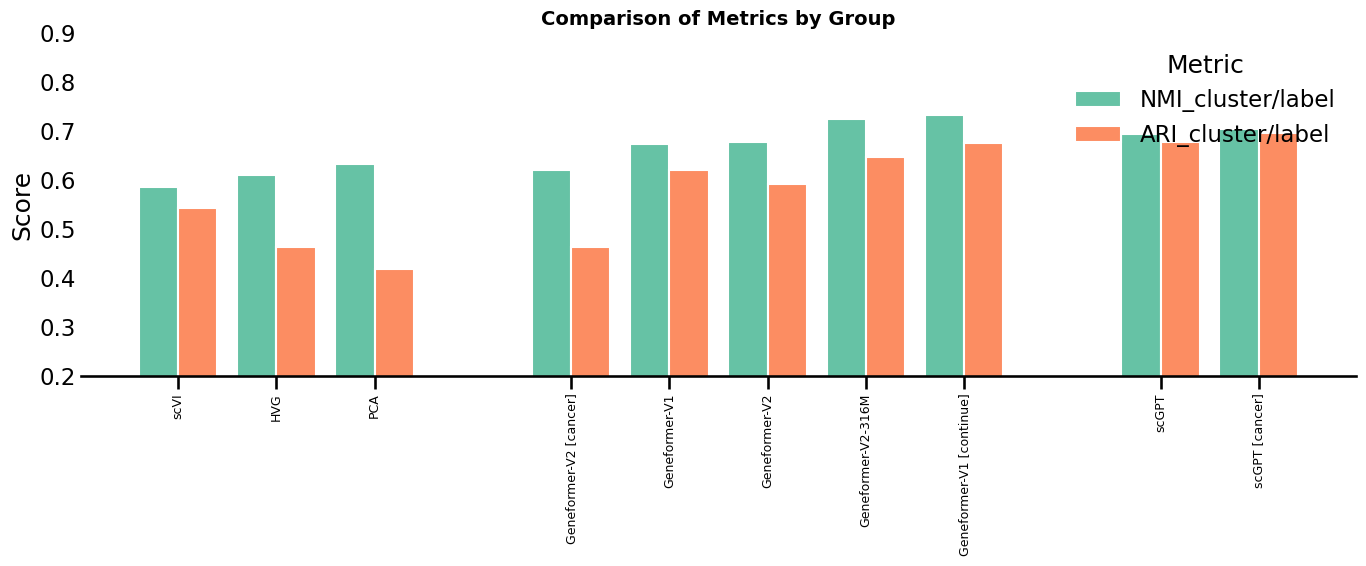

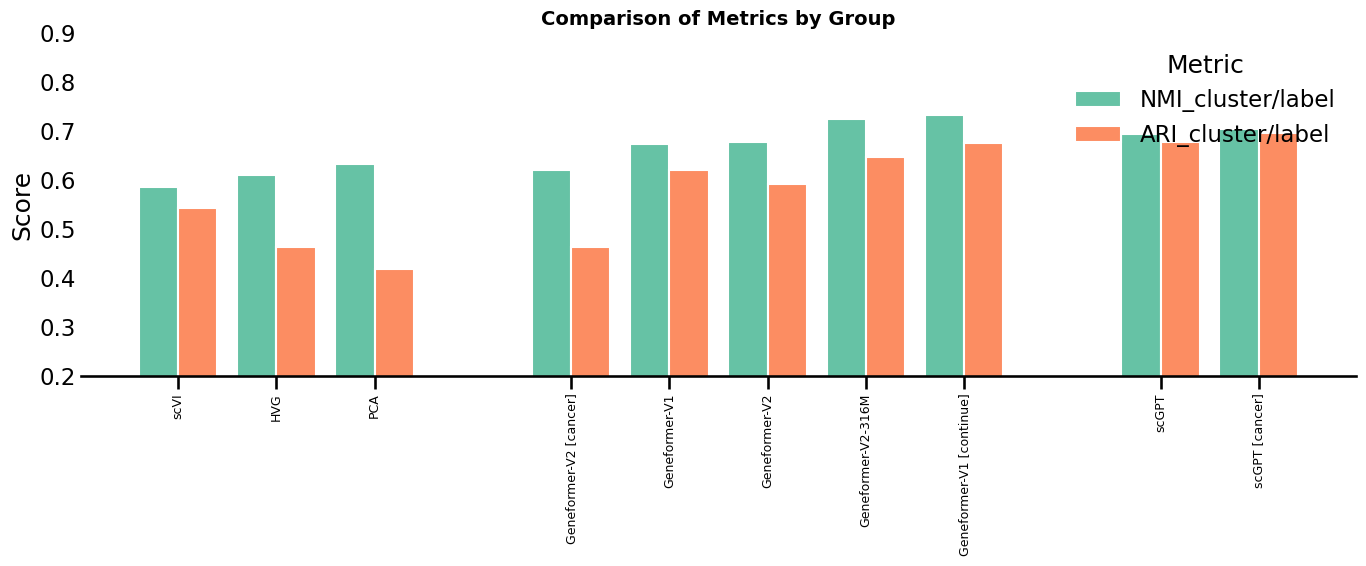

In [115]:
plot_groups(dd, cols=['NMI_cluster/label', 'ARI_cluster/label'])

In [116]:
all_results

{'hvg': [{'NMI_cluster/label': 0.6185937629059547,
   'ARI_cluster/label': 0.5172636565099454,
   'ASW_label': 0.5060959078474538,
   'graph_conn': 0.976195527248799,
   'ASW_batch': 0.4893313885315743,
   'ASW_label/batch': 0.9540160372996372,
   'PCR_batch': 0.02554393035284646,
   'avg_bio': 0.5473177757544513},
  {'NMI_cluster/label': 0.5509030689384139,
   'ARI_cluster/label': 0.27904140963107654,
   'ASW_label': 0.5066311985747931,
   'graph_conn': 0.9842464272172616,
   'ASW_batch': 0.48921582278626546,
   'ASW_label/batch': 0.9620516823662104,
   'PCR_batch': 0.025269273458113504,
   'avg_bio': 0.4455252257147612},
  {'NMI_cluster/label': 0.5472063106197586,
   'ARI_cluster/label': 0.2656988931272916,
   'ASW_label': 0.5059028304339658,
   'graph_conn': 0.9753041715390048,
   'ASW_batch': 0.48789503386625943,
   'ASW_label/batch': 0.9570900132006676,
   'PCR_batch': 0.025930957512898187,
   'avg_bio': 0.43960267806033865},
  {'NMI_cluster/label': 0.6529813370246583,
   'ARI_clu

In [117]:
# Convert to DataFrame with method as additional column
df_list = []
for method, records in all_results.items():
    df = pd.DataFrame(records)
    df["method"] = method
    df_list.append(df)

result_df = pd.concat(df_list, ignore_index=True)
result_df

,NMI_cluster/label,ARI_cluster/label,ASW_label,graph_conn,ASW_batch,ASW_label/batch,PCR_batch,avg_bio,method
0,0.618594,0.517264,0.506096,0.976196,0.489331,0.954016,0.025544,0.547318,hvg
1,0.550903,0.279041,0.506631,0.984246,0.489216,0.962052,0.025269,0.445525,hvg
2,0.547206,0.265699,0.505903,0.975304,0.487895,0.957090,0.025931,0.439603,hvg
3,0.652981,0.534857,0.506293,0.986023,0.491267,0.954607,0.024398,0.564710,hvg
4,0.644670,0.600790,0.505742,0.977590,0.489405,0.957718,0.025447,0.583734,hvg
...,...,...,...,...,...,...,...,...,...
105,0.743958,0.698617,0.534029,0.970643,0.498282,0.939199,0.029617,0.658868,gf-6L-30M-i2048_continue
106,0.713599,0.642156,0.532762,0.955106,0.494671,0.921723,0.032414,0.629506,gf-6L-30M-i2048_continue
107,0.729149,0.656506,0.534705,0.955533,0.495740,0.919900,0.030541,0.640120,gf-6L-30M-i2048_continue
108,0.720899,0.662533,0.532969,0.957227,0.496563,0.918935,0.029298,0.638800,gf-6L-30M-i2048_continue


In [ ]:
result_df['group'] = result_df['method'].map(map_groups)
result_df.set_index('method', inplace=True)
result_df.to_csv('metrics_runs.csv')

## PLOTS

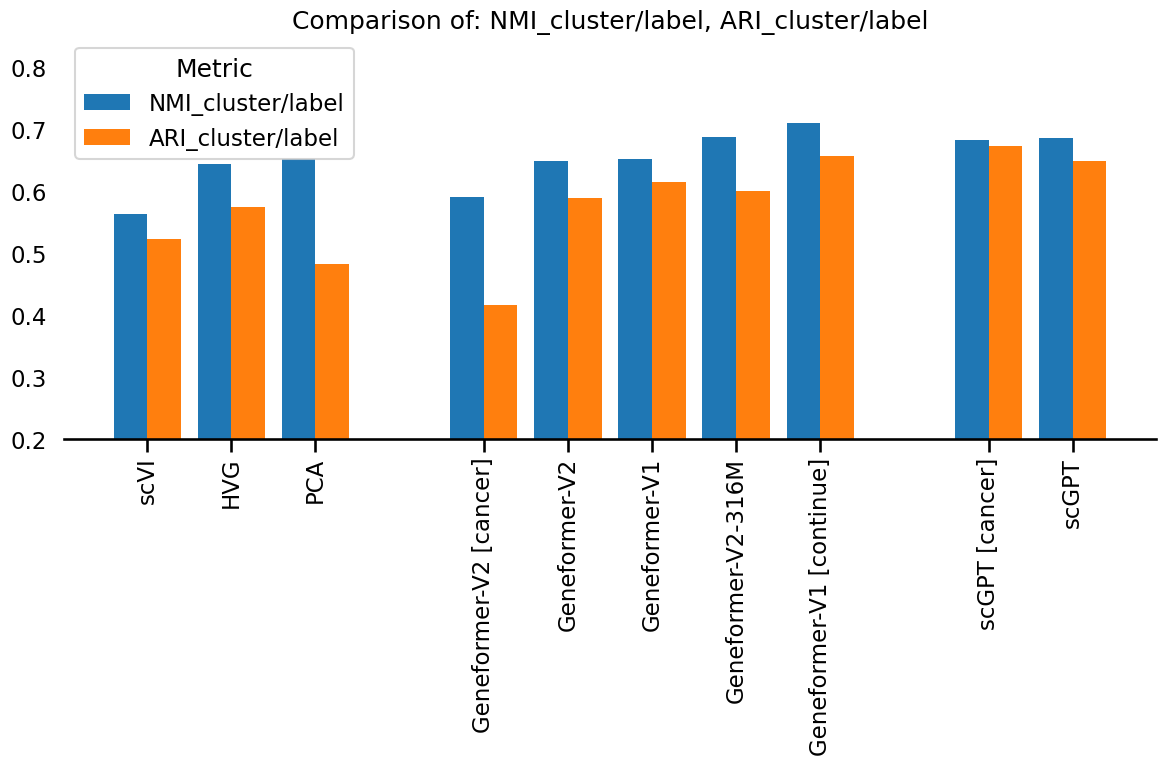

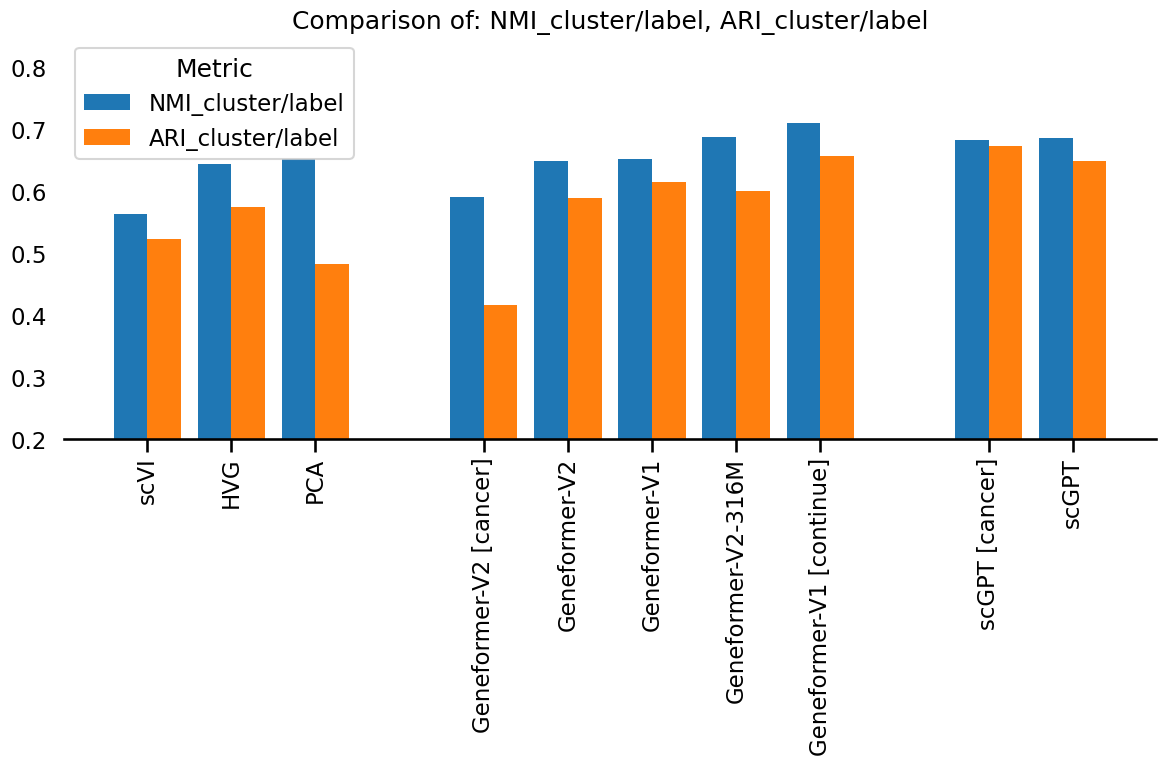

In [81]:
plot_groups(dd, cols=['NMI_cluster/label', 'ARI_cluster/label'])

In [129]:
result_df[['NMI_cluster/label', 'group']].to_csv('nmi.csv')

In [130]:
nmi_df = result_df[['NMI_cluster/label', 'group']]

In [133]:
nmi_df

,NMI_cluster/label,group
method,,
hvg,0.618594,baseline
hvg,0.550903,baseline
hvg,0.547206,baseline
hvg,0.652981,baseline
hvg,0.644670,baseline
...,...,...
gf-6L-30M-i2048_continue,0.743958,geneformer
gf-6L-30M-i2048_continue,0.713599,geneformer
gf-6L-30M-i2048_continue,0.729149,geneformer


/var/tmp/ipykernel_2937973/2184321380.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/tmp/ipykernel_2937973/2184321380.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/tmp/ipykernel_2937973/2184321380.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


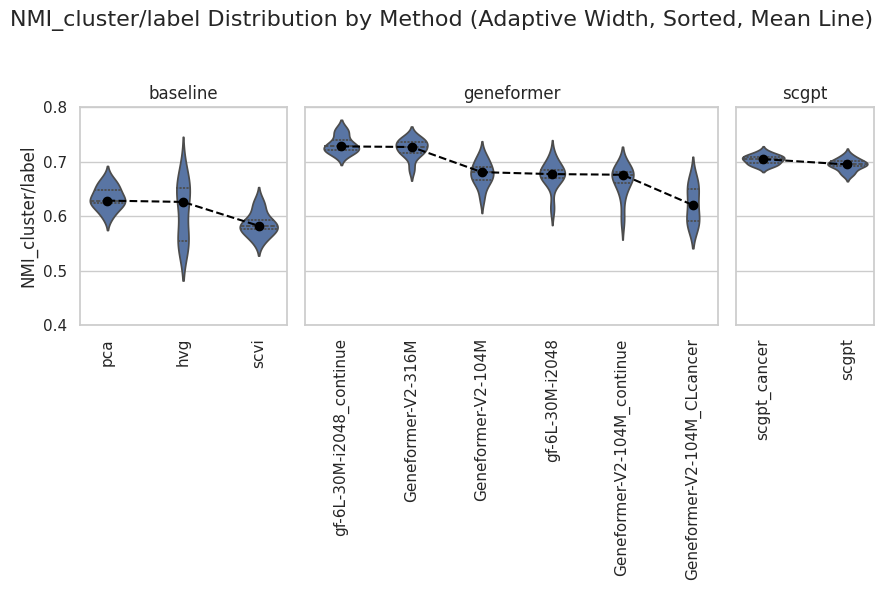

In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import itertools
import matplotlib.gridspec as gridspec
# nmi_df = nmi_df.reset_index()
sns.set(style="whitegrid")

# Get unique groups and count number of methods per group
group_method_counts = nmi_df.groupby("group")["method"].nunique()
total_methods = group_method_counts.sum()

# Create grid with proportional width ratios
fig = plt.figure(figsize=(6 * len(group_method_counts)/2, 6))
gs = gridspec.GridSpec(1, len(group_method_counts), width_ratios=group_method_counts.values, figure=fig)

# Plot each group
for idx, (group, method_count) in enumerate(group_method_counts.items()):
    ax = fig.add_subplot(gs[0, idx])
    subset = nmi_df[nmi_df['group'] == group].copy()

    # Sort methods by mean
    method_stats = subset.groupby("method")["NMI_cluster/label"].median().sort_values(ascending=False)
    ordered_methods = method_stats.index.tolist()
    subset["method"] = pd.Categorical(subset["method"], categories=ordered_methods, ordered=True)

    # Violin plot
    sns.violinplot(
        data=subset,
        x="method",
        y="NMI_cluster/label",
        ax=ax,
        inner="quartile",
        scale="area",
        # cut=0,
        width=0.5
    )

    # Add line plot for means
    stat_values = subset.groupby("method")["NMI_cluster/label"].median()[ordered_methods].values
    ax.plot(range(len(ordered_methods)), stat_values, marker='o', linestyle='--', color='black', label='Mean')

    ax.set_title(f"{group}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel('')
    ax.set_ylim(0.4, .8)
    if idx !=0 :
        ax.set_yticklabels([])  # Hide the tick labels only, keep ticks and grid
        ax.set_ylabel("")       # Remove the y-axis label (optional)
        # ax.tick_params(axis='y', which='both', left=False)  # Remove tick marks

# for i, ax in enumerate(axes):
#     if i != 0:
#         ax.set_yticks([])             # Remove y-axis ticks
#         ax.set_ylabel("")             # Remove y-axis label (if any)
#         ax.tick_params(axis='y', which='both', left=False)  # Remove tick marks
        
# Overall title and layout
fig.suptitle("NMI_cluster/label Distribution by Method (Adaptive Width, Sorted, Mean Line)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

def plot_metric_by_group_violin(df, metric_col="NMI_cluster/label", title=None, ylim=(0.4, 0.8)):
    """
    Plots a violin plot of the specified metric for each group, with adaptive subplot widths.
    
    Parameters:
    - df (pd.DataFrame): Input DataFrame with columns 'group', 'method', and the metric.
    - metric_col (str): Column name of the metric to plot.
    - title (str): Optional title for the entire plot.
    - ylim (tuple): Y-axis limits.
    """

    sns.set(style="whitegrid")

    # Get unique groups and method counts
    group_method_counts = df.groupby("group")["method"].nunique()
    total_methods = group_method_counts.sum()

    # Set up figure and grid
    fig = plt.figure(figsize=(6 * len(group_method_counts) / 2, 6))
    gs = gridspec.GridSpec(1, len(group_method_counts), width_ratios=group_method_counts.values, figure=fig)

    for idx, (group, method_count) in enumerate(group_method_counts.items()):
        ax = fig.add_subplot(gs[0, idx])
        subset = df[df['group'] == group].copy()

        # Sort methods by median
        method_stats = subset.groupby("method")[metric_col].median().sort_values(ascending=False)
        ordered_methods = method_stats.index.tolist()
        subset["method"] = pd.Categorical(subset["method"], categories=ordered_methods, ordered=True)

        # Violin plot
        sns.violinplot(
            data=subset,
            x="method",
            y=metric_col,
            ax=ax,
            inner="quartile",
            scale="area",
            width=0.5
        )

        # Line plot for group medians
        stat_values = subset.groupby("method")[metric_col].median()[ordered_methods].values
        ax.plot(range(len(ordered_methods)), stat_values, marker='o', linestyle='--', color='black', label='Median')

        ax.set_title(f"{group}")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_xlabel('')
        ax.set_ylim(*ylim)
        if idx != 0:
            ax.set_yticklabels([])
            ax.set_ylabel("")

    # Final layout and title
    plot_title = title or f"{metric_col} Distribution by Method (Grouped)"
    fig.suptitle(plot_title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [3]:
nmi_df

NameError: name 'nmi_df' is not defined

In [2]:
plot_metric_by_group_violin(nmi_df, metric_col="NMI_cluster/label")


NameError: name 'nmi_df' is not defined

In [137]:
import pandas as pd
from scipy.stats import ttest_ind, f_oneway
import itertools
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt

# Define group order
group_order = ['baseline', 'geneformer', 'scgpt']
nmi_df['group'] = pd.Categorical(nmi_df['group'], categories=group_order, ordered=True)
nmi_df = nmi_df.sort_values('group')

# Initialize list to collect test results
test_results = []
unique_groups = nmi_df['group'].cat.categories

# Pairwise t-tests within each group
for group in unique_groups:
    subset = nmi_df[nmi_df['group'] == group].copy()
    method_order = subset.groupby('method')['NMI_cluster/label'].mean().sort_values(ascending=False).index
    
    for m1, m2 in itertools.combinations(method_order, 2):
        vals1 = subset[subset["method"] == m1]["NMI_cluster/label"]
        vals2 = subset[subset["method"] == m2]["NMI_cluster/label"]
        if len(vals1) > 1 and len(vals2) > 1:
            stat, pval = ttest_ind(vals1, vals2)
            test_results.append({
                'group': group,
                'method1': m1,
                'method2': m2,
                'raw_p': pval,
                'statistic': stat
            })

# One-way ANOVA across groups
anova_stat, anova_p = f_oneway(
    *[nmi_df[nmi_df['group'] == g]['NMI_cluster/label'] for g in unique_groups]
)
test_results.append({
    'group': 'ALL_GROUPS',
    'method1': 'ANOVA',
    'method2': '',
    'raw_p': anova_p,
    'statistic': anova_stat
})

# Convert to DataFrame
results_df = pd.DataFrame(test_results)

# Apply multiple comparison correction (FDR)
_, corrected_pvals, _, _ = multipletests(results_df['raw_p'], method='fdr_bh')
results_df['FDR_adj_p'] = corrected_pvals
results_df['significant'] = results_df['FDR_adj_p'] < 0.05

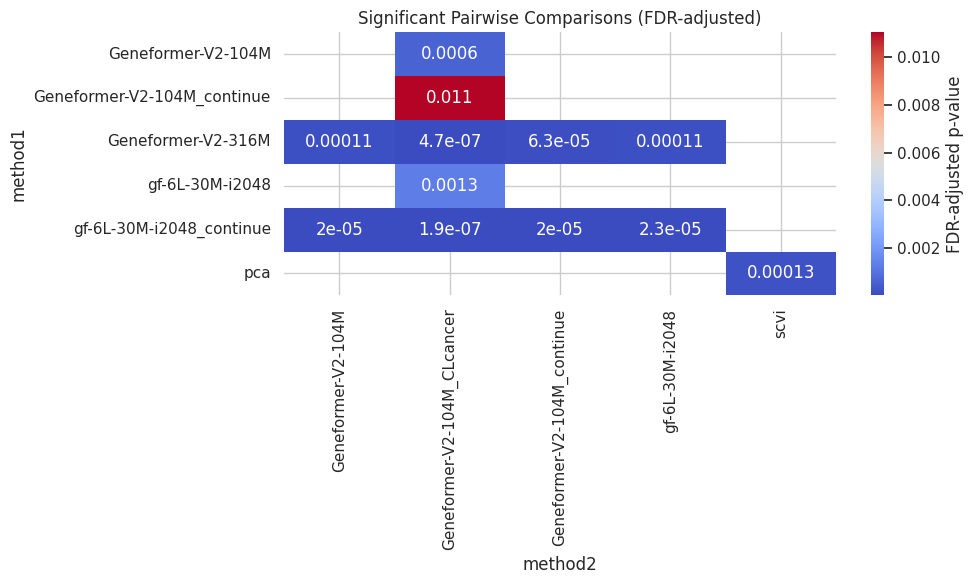

In [138]:
# Save to CSV
results_df.to_csv("nmi_stats_corrected.csv", index=False)

# Plot significant results (heatmap-like)
significant_df = results_df[(results_df['group'] != 'ALL_GROUPS') & (results_df['significant'])]

# Create a pivot table for heatmap
if not significant_df.empty:
    heatmap_data = significant_df.pivot(index='method1', columns='method2', values='FDR_adj_p')
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".2g", cmap="coolwarm", cbar_kws={'label': 'FDR-adjusted p-value'})
    plt.title("Significant Pairwise Comparisons (FDR-adjusted)")
    plt.tight_layout()
    plt.savefig("nmi_significant_heatmap.png", dpi=300)
    plt.show()
else:
    print("No significant pairwise comparisons after FDR correction.")